### SETUP 

In [21]:
import torch

def ifft2c(data):
    """Centered 2D inverse FFT using torch.fft"""
    data = torch.fft.ifftshift(data, dim=(-2, -1))
    data = torch.fft.ifft2(data, dim=(-2, -1), norm='ortho')
    return torch.fft.fftshift(data, dim=(-2, -1))

def complex_abs(data):
    """Magnitude of complex-valued tensor"""
    return torch.sqrt(data.real**2 + data.imag**2)

In [ ]:
!!pip install -e .

In [ ]:
!python -c "import fastmri; print('fastMRI version:', fastmri.__version__)"

In [22]:
%matplotlib inline

import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Core transforms from the fastMRI repo
from fastmri.data import SliceDataset

# Adjust this path to point at the folder that *contains* the "fastmri" directory.
repo_root = "/Users/jameswilson/Desktop/DL Group Project/fastMRI"
sys.path.insert(0, repo_root)


from fastmri.data.transforms import to_tensor, tensor_to_complex_np         # :contentReference[oaicite:0]{index=0}
from fastmri.data.transforms import apply_mask, center_crop                  # :contentReference[oaicite:1]{index=1}
from fastmri import complex_abs                    # magnitude for complex tensors

# from fastmri.fft_functions      import ifft2c, fft2c


### EDA 


In [6]:
file_name = 'data/singlecoil_test/file1002402.h5'
hf = h5py.File(file_name)

print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 4, 'acquisition': 'CORPDFS_FBK', 'num_low_frequency': 29, 'patient_id': '5dfc4eec45b0685dc23fd98844c22725692c8cf0f6bfa3367bbedaf3a53711ec'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [7]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(37, 640, 368)


In [8]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
slice_kspace.shape

(640, 368)

Review some of the data

In [10]:
# Utilities for FFT and image conversion
def ifft2c(data):
    data = torch.fft.ifftshift(data, dim=(-2, -1))
    data = torch.fft.ifft2(data, dim=(-2, -1), norm='ortho')
    return torch.fft.fftshift(data, dim=(-2, -1))

def complex_abs(data):
    return torch.sqrt(data.real**2 + data.imag**2)

def to_tensor(data):
    return torch.tensor(data, dtype=torch.complex64)

# Visualize k-space + image from single-coil slice
def show_kspace_and_reconstruction(kspace_slice):
    kspace_np = np.abs(kspace_slice)
    kspace_log = np.log(kspace_np + 1e-9)

    kspace_tensor = to_tensor(kspace_slice)
    image_tensor = ifft2c(kspace_tensor)
    image_abs = complex_abs(image_tensor)
    image_norm = (image_abs - image_abs.min()) / (image_abs.max() - image_abs.min())

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(kspace_log, cmap='gray')
    plt.title("Raw K-space (log scale)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image_norm.numpy(), cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
K-space shape: (34, 640, 368)


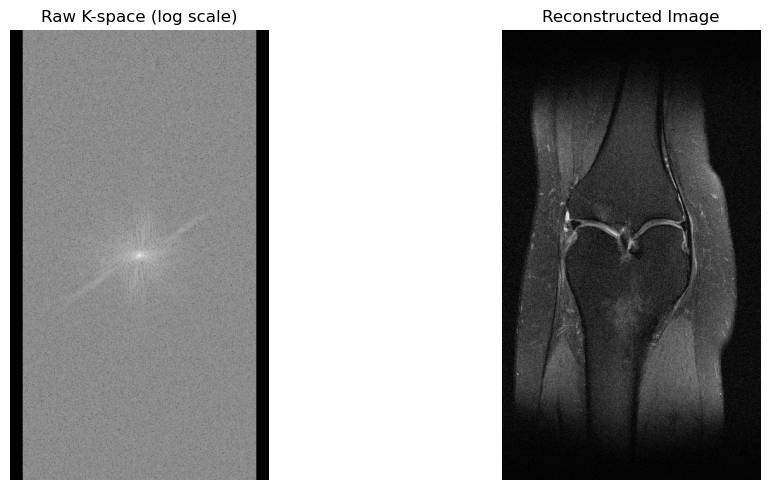

In [11]:
# Adjust path if needed
example_file = 'data/singlecoil_train/file1000027.h5'

with h5py.File(example_file, "r") as hf:
    print("Keys:", list(hf.keys()))
    volume_kspace = hf["kspace"][:]
    print("K-space shape:", volume_kspace.shape)

# Grab a slice and visualize
slice_kspace = volume_kspace[20]  # 21st slice
show_kspace_and_reconstruction(slice_kspace)

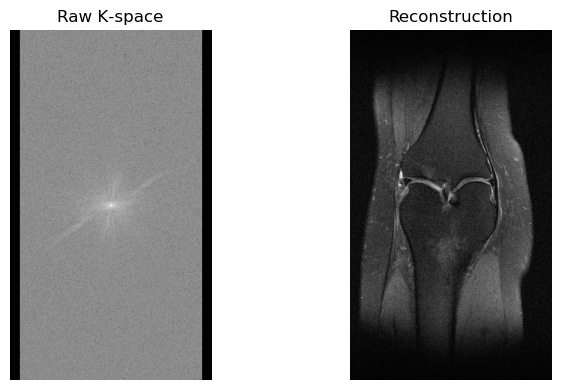

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from fastmri.data.transforms import to_tensor, tensor_to_complex_np
import fastmri.data.transforms as _ft

# --- Inline FFT helper ---
def ifft2c(data):
    """Centered 2D inverse FFT using torch.fft"""
    data = torch.fft.ifftshift(data, dim=(-2, -1))
    data = torch.fft.ifft2(data, dim=(-2, -1), norm='ortho')
    return torch.fft.fftshift(data, dim=(-2, -1))

# --- Custom magnitude for complex tensors ---
def complex_mag(data):
    """Magnitude of a complex-valued tensor (torch.complex64)"""
    return data.abs()


def tensor_to_complex_np(data: torch.Tensor) -> np.ndarray:
    """
    Convert a PyTorch tensor to a NumPy complex64 array.
    - If `data` is already complex dtype, just call .numpy()
    - Otherwise assume real/imag stacked last dim and use view_as_complex
    """
    if torch.is_complex(data):
        return data.cpu().numpy()
    else:
        return torch.view_as_complex(data).cpu().numpy()

# Override the broken implementation
_ft.tensor_to_complex_np = tensor_to_complex_np


# Numpy → real‑imag torch tensor
#    (to_tensor stacks real/imag into last dim → float tensor shape [H,W,2])
slice_kspace = volume_kspace[20]              # 2D NumPy array, shape (H, W)

# 1) real/imag float tensor
k_t = to_tensor(slice_kspace)           # shape [H, W, 2]

# 2) stack → complex dtype
k_c = torch.view_as_complex(k_t)        # shape [H, W], dtype=complex64

# 3) inverse FFT + magnitude
img_c   = ifft2c(k_c)                   # complex image
# img_abs = complex_abs(img_c)            # real magnitude image
img_abs = complex_mag(img_c)                   # real magnitude tensor

# 4) back to NumPy if you need it
img_np_complex = tensor_to_complex_np(img_c)   # shape [H, W], complex64

# 6) visualize
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(slice_kspace)+1e-9), cmap='gray')
plt.title("Raw K‑space")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_abs.cpu().numpy(), cmap='gray')
plt.title("Reconstruction")
plt.axis('off')
plt.tight_layout()
plt.show()

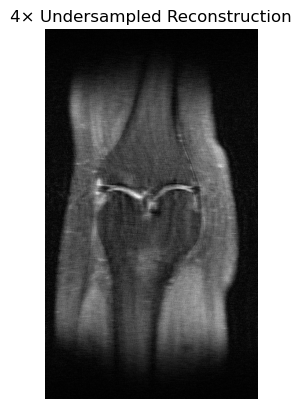

In [30]:
# 0️⃣ Imports
from fastmri.data.subsample import RandomMaskFunc, create_mask_for_mask_type
from fastmri.data.transforms import to_tensor, apply_mask

# 1️⃣ Prepare your k-space tensor (real/imag float) with a batch dim
k_t = to_tensor(slice_kspace).unsqueeze(0)    # -> shape (1, H, W, 2)

# 2️⃣ Instantiate a *concrete* mask function, e.g. RandomMaskFunc:
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])

# —OR— via the factory:
# mask_func = create_mask_for_mask_type("random", [0.08], [4])

# 3️⃣ Apply the mask
k_t_masked, mask, num_low_freqs = apply_mask(k_t, mask_func)
#   • k_t_masked: (1, H, W, 2)
#   • mask      : (1, H, W)
#   • num_low_freqs: int

# 4️⃣ Strip the batch dim, then to complex
k_t_masked = k_t_masked.squeeze(0)           # -> (H, W, 2)
k_c_masked = torch.view_as_complex(k_t_masked)  # -> (H, W), complex64

# 5️⃣ IFFT + magnitude
img_c   = ifft2c(k_c_masked)
img_abs = img_c.abs()

# 6️⃣ Visualize
import matplotlib.pyplot as plt
plt.imshow(img_abs.cpu().numpy(), cmap="gray")
plt.title("4× Undersampled Reconstruction")
plt.axis("off")
plt.show()


### Run U-Net

In [ ]:
# dependencies:
#   - pip
#   - pip:
#       - pytorch-lightning<2.0  # e.g. 1.9.4

In [36]:
# !pip install pytorch-lightning==1.9.4
!conda install -c conda-forge libjpeg-turbo


Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [42]:
from fastmri.data import SliceDataset
from torch.utils.data import DataLoader
import os

# 1) Where your H5s actually live:
data_parent = "data"                       # parent folder
challenge   = "singlecoil"

# point at the train‐split folder, not at `data/` itself:
train_root = os.path.join(data_parent, f"{challenge}_train")

# 2) Define a top‐level transform (no lambda!)
def identity_transform(kspace, mask, target, attrs, fname, slice):  
    return kspace, mask, target, attrs, fname, slice

def always_true(x):
    return True

# 3) Build the dataset (only sample_rate set)
dataset = SliceDataset(
    root=train_root,
    challenge=challenge,
    transform=identity_transform,
    sample_rate=1.0,           # keep every slice
    volume_sample_rate=None,   # explicitly None
    raw_sample_filter=always_true
)

# 4) Wrap in a DataLoader
loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# 5) Sanity‐check one batch
batch = next(iter(loader))
print("Batch returned:", tuple(type(x) for x in batch))
print("  • kspace tensor shape:", batch[0].shape)  # e.g. (4, H, W)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fastmri/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/fastmri/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'identity_transform' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [45]:
# in a notebook cell, after you’ve added repo root to sys.path

from pathlib import Path
from argparse import Namespace
from fastmri_examples.unet.train_unet_demo import cli_main


def always_true(x):
    return True

# 1) Construct a fake args object
args = Namespace(
    mode="train",

    data_path="/Users/jameswilson/Desktop/DL Group Project/fastMRI/data", 
    test_path=None,

    challenge="singlecoil",
    mask_type="random",
    center_fractions=[0.08],
    accelerations=[4],
    sample_rate=1.0,
    test_split="val",
    batch_size=4,
    num_workers=4,
    in_chans=1,
    out_chans=1,
    chans=32,
    num_pool_layers=4,
    drop_prob=0.0,
    lr=1e-3,
    lr_step_size=40,
    lr_gamma=0.1,
    weight_decay=0.0,
    accelerator="mps",
    devices=1,            # Lightning≥2.0
    strategy="auto",
    max_epochs=50,
    # default_root_dir="./logs/unet_demo",
    default_root_dir=Path("./logs/unet_demo"),    # ← use Path, not str
    seed=42,
    deterministic=True,
    replace_sampler_ddp=False,
    resume_from_checkpoint=None,
    callbacks=None,       # will be set by build_args in the script
    raw_sample_filter=always_true

)

# 2) Launch training
cli_main(args)


Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [ ]:
import sys, importlib
from pathlib import Path
from fastmri_examples.unet.train_unet_demo import build_args, cli_main

# ─── 0) Reload transforms to get back the original to_tensor ────────────
import fastmri.data.transforms as transforms_module
importlib.reload(transforms_module)

# Grab the *real* original to_tensor
_original_to_tensor = transforms_module.to_tensor


# Patch it exactly once to force float32
def to_tensor_float32(data):
    return _original_to_tensor(data).float()

transforms_module.to_tensor = to_tensor_float32

# ─── 1) Clean argv for build_args() ────────────────────────────────────
_orig_argv = sys.argv
sys.argv = ["train_unet_demo.py"]
args = build_args()
sys.argv = _orig_argv

# ─── 2) Override only the essentials ────────────────────────────────────
args.mode             = "train"
args.data_path        = Path("/Users/jameswilson/Desktop/DL Group Project/fastMRI/data")
args.test_path        = None
args.challenge        = "singlecoil"
args.mask_type        = "random"
args.center_fractions = [0.08]
args.accelerations    = [4]
args.sample_rate      = 1.0
args.test_split       = "val"

args.batch_size       = 4
args.num_workers      = 0      # disable workers to avoid pickling issues
args.max_epochs       = 50
args.lr               = 1e-3

args.gpus             = 1
args.accelerator      = "mps"
args.devices          = 1
args.strategy         = "auto"

# YAN FIX 
def always_true(x):
    return True
args.raw_sample_filter = always_true


# ─── 3) Launch training ─────────────────────────────────────────────────
cli_main(args)



Global seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type                 | Params
----------------------------------------------------------
0 | NMSE             | DistributedMetricSum | 0     
1 | SSIM             | DistributedMetricSum | 0     
2 | PSNR             | DistributedMetricSum | 0     
3 | ValLoss          | DistributedMetricSum | 0     
4 | TotExamples      | DistributedMetricSum | 0     
5 | TotSliceExamples | DistributedMetricSum | 0     
6 | unet             | Unet                 | 7.8 M 
----------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.024    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:
import sys, importlib, torch
from pathlib import Path

# ─── 0) Reload and patch fastMRI utilities ───────────────────────────────
import fastmri.data.transforms as transforms_module
import fastmri            as fmri_module

importlib.reload(transforms_module)
importlib.reload(fmri_module)  

# Patch to_tensor → float32
_orig_to_tensor = transforms_module.to_tensor
def to_tensor_float32(data):
    return _orig_to_tensor(data).float()
transforms_module.to_tensor = to_tensor_float32

# Patch fft and abs at the top‐level fastmri namespace
def ifft2c_torch(data):
    data = torch.fft.ifftshift(data, dim=(-2, -1))
    data = torch.fft.ifft2(data, dim=(-2, -1), norm='ortho')
    return torch.fft.fftshift(data, dim=(-2, -1))
fmri_module.ifft2c      = ifft2c_torch
fmri_module.complex_abs = lambda x: x.abs()

# ─── 1) Prepare the demo’s args ─────────────────────────────────────────
from fastmri_examples.unet.train_unet_demo import build_args, cli_main

# Wipe out notebook argv so build_args() only sees script name
_saved_argv = sys.argv
sys.argv    = ["train_unet_demo.py"]
args        = build_args()
sys.argv    = _saved_argv

# ─── 2) Override only what you care about ────────────────────────────────
args.mode             = "train"
args.data_path        = Path("/Users/jameswilson/Desktop/DL Group Project/fastMRI/data")
args.test_path        = None
args.challenge        = "singlecoil"
args.mask_type        = "random"
args.center_fractions = [0.08]
args.accelerations    = [4]
args.sample_rate      = 1.0
args.test_split       = "val"

args.batch_size   = 4
args.num_workers  = 0        # disable workers & any pickling issues
args.max_epochs   = 50
args.lr           = 1e-3

# Lightning on MPS (single device)
args.gpus        = 1         # (Lightning 1.x)
args.accelerator = "mps"     # (Lightning 2.x)
args.devices     = 1         # (Lightning 2.x)
args.strategy    = "auto"

# YAN FIX 
args.raw_sample_filter = always_true


# ─── 3) Run the CLI trainer ───────────────────────────────────────────────
cli_main(args)


In [ ]:
import importlib
import torch
from pathlib import Path
from fastmri_examples.unet.train_unet_demo import build_args, cli_main

# ─── 0) Monkey‐patch all fastMRI data transforms to use float32 ─────────
import fastmri.data.transforms as transforms_module
importlib.reload(transforms_module)  # ensure we have the original definitions

# 0a) Patch to_tensor → float32
_orig_to_tensor = transforms_module.to_tensor
def to_tensor_float32(data):
    return _orig_to_tensor(data).float()
transforms_module.to_tensor = to_tensor_float32

# 0b) Patch UnetDataTransform.__call__ → cast all returned Tensors
_orig_unet_call = transforms_module.UnetDataTransform.__call__
def unet_call_float32(self, kspace, mask, target, attrs, fname, slice_num):
    out = _orig_unet_call(self, kspace, mask, target, attrs, fname, slice_num)
    casted = []
    for x in out:
        if isinstance(x, torch.Tensor):
            # if it's complex128 or float64, cast down
            if x.is_complex():
                if x.dtype != torch.complex64:
                    casted.append(x.to(torch.complex64))
                else:
                    casted.append(x)
            else:
                casted.append(x.float())
        else:
            casted.append(x)
    return tuple(casted)

transforms_module.UnetDataTransform.__call__ = unet_call_float32
# ──────────────────────────────────────────────────────────────────────────

# ─── 1) Wipe notebook argv & build base args ──────────────────────────────
import sys
_saved_argv = sys.argv
sys.argv = ["train_unet_demo.py"]
args = build_args()
sys.argv = _saved_argv

# ─── 2) Override only what you need ────────────────────────────────────────
args.mode             = "train"
args.data_path        = Path("/Users/jameswilson/Desktop/DL Group Project/fastMRI/data")
args.challenge        = "singlecoil"
args.mask_type        = "random"
args.center_fractions = [0.08]
args.accelerations    = [4]
args.sample_rate      = 1.0
args.test_split       = "val"
args.batch_size       = 4
args.num_workers      = 0        # disable workers to avoid pickling issues
args.max_epochs       = 50
args.lr               = 1e-3
args.gpus             = 1        # Lightning 1.x
args.accelerator      = "mps"    # Lightning 2.x
args.devices          = 1        # Lightning 2.x
args.strategy         = "auto"

# YAN FIX 
args.raw_sample_filter = always_true


# ─── 3) Launch training ───────────────────────────────────────────────────
cli_main(args)


In [ ]:
# from fastmri.data import SliceDataset
# from fastmri.pl_modules import FastMriDataModule
# from fastmri.data.transforms import UnetDataTransform
# from fastmri.data.subsample import create_mask_for_mask_type
# from pytorch_lightning import Trainer
# import torch
# from pathlib import Path

# pl.seed_everything(42)

# # 1) Prepare the mask & transforms exactly as before
# mask     = create_mask_for_mask_type("random", [0.08], [4])
# train_tf = UnetDataTransform("singlecoil", mask_func=mask, use_seed=False)
# val_tf   = UnetDataTransform("singlecoil", mask_func=mask)
# test_tf  = UnetDataTransform("singlecoil", mask_func=None)

# # 2) Tell the dataset to cache its slice‐index list + headers to a file
# cache_file = Path("/tmp/fastmri_knee_cache.pkl")

# data_module = FastMriDataModule(
#     data_path        = Path("/Users/jameswilson/.../fastMRI/data"),
#     challenge        = "singlecoil",
#     train_transform  = train_tf,
#     val_transform    = val_tf,
#     test_transform   = test_tf,
#     test_split       = "val",
#     batch_size       = 4,
#     num_workers      = 0,               # or >0 once the lambdas are sorted
#     use_dataset_cache_file = True,      # turn on caching
#     dataset_cache_file     = cache_file # where to store the pickle
# )

# # 3) Build your model & trainer as before
# from fastmri.pl_modules import UnetModule
# model = UnetModule(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0,
#                    lr=1e-3, lr_step_size=40, lr_gamma=0.1, weight_decay=0.0)

# trainer = Trainer(
#     accelerator="mps", devices=1, strategy="auto",
#     max_epochs=50, precision=32
# )

# # 4) Fit—initial metadata reading will hit the cache file next time
# trainer.fit(model, datamodule=data_module)


In [ ]:
import pytorch_lightning as pl
from pathlib            import Path
from fastmri.data.subsample     import create_mask_for_mask_type
from fastmri.data.transforms    import UnetDataTransform
from fastmri.pl_modules         import FastMriDataModule, UnetModule
from pytorch_lightning           import Trainer

# 1) Reproducibility
pl.seed_everything(42)

# 2) Build the U‑Net transforms
mask     = create_mask_for_mask_type("random", [0.08], [4])
train_tf = UnetDataTransform("singlecoil", mask_func=mask, use_seed=False)
val_tf   = UnetDataTransform("singlecoil", mask_func=mask)
test_tf  = UnetDataTransform("singlecoil", mask_func=None)


# YAN FIX 
def always_true(x):
    return True
# args.raw_sample_filter = always_true


# 3) Build the DataModule (single‑coil knee)
data_module = FastMriDataModule(
    data_path     = Path("/Users/jameswilson/Desktop/DL Group Project/fastMRI/data"),
    challenge     = "singlecoil",
    train_transform = train_tf,
    val_transform   = val_tf,
    test_transform  = test_tf,
    test_split      = "val",
    batch_size      = 4,
    num_workers     = 4,       # feel free to increase if you like
)

# 4) Instantiate the LightningModule (the U‑Net)
model = UnetModule(
    in_chans       = 1,
    out_chans      = 1,
    chans          = 32,
    num_pool_layers= 4,
    drop_prob      = 0.0,
    lr             = 1e-3,
    lr_step_size   = 40,
    lr_gamma       = 0.1,
    weight_decay   = 0.0,
)

# 5) Trainer on CPU (no more MPS float64 issues)
trainer = Trainer(
    accelerator = "cpu",       # run on your MacBook’s CPU
    devices     = 1,
    max_epochs  = 50,
    precision   = 32,          # float32 everywhere
)

# 6) Kick off training
trainer.fit(model, datamodule=data_module)


Global seed set to 42


TypeError: FastMriDataModule.__init__() got an unexpected keyword argument 'raw_sample_filter'

In [ ]:
# !python fastmri_examples/unet/train_unet_demo.py \
#   --mode train \
#   --data_path     data/ \
#   --challenge     singlecoil \
#   --max_epochs    10 \
#   --batch_size    4 \
#   --gpus          1 \
#   --strategy      auto \
#   --accelerator   mps \
#   --num_workers   4 \
#   --lr            1e-3 \
#   --log_every_n_steps 50

– train_unet_demo.py defines and trains the exact U‑Net baseline from the paper 
GitHub

– accelerator mps lets you leverage Apple’s Metal Performance Shaders on M1/M2.
fastmri_examples/unet/unet_demo/checkpoints/epoch=<N>-step=*.ckpt


In [ ]:
# !python fastmri_examples/unet/run_pretrained_unet_inference.py \
#   --data_path /path/to/fastMRI_DATASET/knee_singlecoil_test/ \
#   --output_path ./reconstructions/ \
#   --checkpoint_path fastmri_examples/unet/unet_demo/checkpoints/epoch=9-step=*.ckpt \
#   --challenge singlecoil

In [ ]:
# # Pick one reconstruction file
# recon_file = "reconstructions/file1000052_recon.h5"
# with h5py.File(recon_file, 'r') as f:
#     recon_vol = f['reconstruction'][()]   # shape (num_slices, H, W)

# # Display the center slice
# slice_idx = recon_vol.shape[0] // 2
# slice_img = recon_vol[slice_idx]

# plt.figure(figsize=(5,5))
# plt.imshow(np.abs(slice_img), cmap='gray')
# plt.title("Reconstructed Slice")
# plt.axis('off')
# plt.show()